First of, install the requirements

In [1]:
!pip install -r requirements.txt

In [2]:
!python -m spacy download sv_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('sv_core_news_sm')


In [3]:
import os
import json
import pandas as pd

# Project Code for topic classification for Swedish parlament dataset

### Start of by creating a data frame out of the jsonl files

In [4]:
jsonl_files = [ "anforande-201314.jsonl", "anforande-201415.jsonl", "anforande-201516.jsonl", "anforande-201617.jsonl", 
                "anforande-201718.jsonl", "anforande-201819.jsonl", "anforande-201920.jsonl", 
                "anforande-202021.jsonl", "anforande-202122.jsonl", "anforande-202223.jsonl", 
                "anforande-202324.jsonl"]

#jsonl_files = [ "anforande-202021.jsonl"]

def jsonl_to_dataframe(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl') and file_name in jsonl_files:
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    record = json.loads(line)
                    data.append(record)  # Append the full record to the list
    return pd.DataFrame(data)

In [5]:
df = jsonl_to_dataframe('data_jsonl')

In [6]:
print(df.shape)
df.head()

(115631, 2)


,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016


In [7]:
df = df[df["dok_datum"] != "2013"]
df = df[df["dok_datum"] != "2024"]

In [8]:
# Drop duplicates based on 'avsnittsrubrik' and 'dok_datum'
df_cleaned = df.drop_duplicates(subset=['avsnittsrubrik', 'dok_datum'])
df_cleaned.reset_index(drop=True)

,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016
...,...,...
13954,Effektivare tillståndsprocesser för elproduktion,2023
13955,Nordisk överenskommelse om skatteavtal för sjömän,2023
13956,House of Sweden i Taiwan,2023
13957,Handläggningstiderna för LSS,2023


In [9]:
print(df_cleaned.shape)
df.head()

(13959, 2)


,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016


In [10]:
# Count the number of rows for each unique value in 'dok_datum'
counts = df_cleaned['dok_datum'].value_counts()

print(counts)

dok_datum
2016    1587
2021    1585
2017    1548
2023    1526
2020    1436
2015    1424
2022    1422
2019    1361
2014    1087
2018     983
Name: count, dtype: int64


### Downsamples so all years are the same size (DONT USE)

In [ ]:
# Determine the minimum count of rows for all years
min_count = df_cleaned['dok_datum'].value_counts().min()

# Downsample each year to the minimum count
df_cleaned = df_cleaned.groupby('dok_datum').apply(lambda x: x.sample(n=min_count, random_state=2)).reset_index(drop=True)

# Verify the result
print(df_cleaned['dok_datum'].value_counts())


dok_datum
2014    983
2015    983
2016    983
2017    983
2018    983
2019    983
2020    983
2021    983
2022    983
2023    983
Name: count, dtype: int64


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_98772/4043757943.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('dok_datum').apply(lambda x: x.sample(n=min_count, random_state=2)).reset_index(drop=True)


### Stop words removal

In [11]:
import spacy
import re
import string

# Load the Swedish language model
nlp = spacy.load("sv_core_news_sm")

# Define a function to clean text
def remove_stopwords_and_unnecessary_patterns(text):
    # Process the text with SpaCy
    doc = nlp(text)
    # Remove stopwords, punctuation, and lowercase the text
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    # Remove patterns containing numbers and fragments like /:, /21, etc.
    cleaned_text = re.sub(r'\b\w*\d+\w*\b', '', cleaned_text)  # Remove words containing numbers (e.g., 2020, 21:722, 2020/21)
    # Remove leftover special character fragments
    cleaned_text = re.sub(r'[/:]+', '', cleaned_text)  # Remove slashes or colons
    # Remove any extra spaces left behind
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply the function to the 'avsnittsrubrik' column
df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['avsnittsrubrik'].apply(remove_stopwords_and_unnecessary_patterns)

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/1925879494.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['avsnittsrubrik'].apply(remove_stopwords_and_unnecessary_patterns)


In [12]:
# Preview the result
print(df_cleaned[['avsnittsrubrik', 'cleaned_avsnittsrubrik']].head())

                                      avsnittsrubrik  \
0                Regelförenklingar på bostadsområdet   
1  Svar på interpellation 2015/16:767 om ett styr...   
2                  Statens budget 2016 - Rambeslutet   
3  Debatt med anledning av vårpropositionens avlä...   
4  Svar på interpellation 2015/16:698 om strategi...   

                              cleaned_avsnittsrubrik  
0                   regelförenklingar bostadsområdet  
1  svar interpellation styr- reglertekniskt forsk...  
2                         statens budget rambeslutet  
3      debatt anledning vårpropositionens avlämnande  
4       svar interpellation strategi säkerhetsrisker  


### Lemmanization

In [13]:
# Load the Swedish SpaCy model
nlp = spacy.load("sv_core_news_sm")

# Define a function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)  # Process the text with SpaCy
    return " ".join([token.lemma_ for token in doc])  # Join lemmatized words back into a string

# Apply lemmatization to the column
df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['cleaned_avsnittsrubrik'].apply(lemmatize_text)

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/4265413163.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['cleaned_avsnittsrubrik'].apply(lemmatize_text)


In [14]:
print(df_cleaned[['avsnittsrubrik', 'cleaned_avsnittsrubrik']].head())

                                      avsnittsrubrik  \
0                Regelförenklingar på bostadsområdet   
1  Svar på interpellation 2015/16:767 om ett styr...   
2                  Statens budget 2016 - Rambeslutet   
3  Debatt med anledning av vårpropositionens avlä...   
4  Svar på interpellation 2015/16:698 om strategi...   

                              cleaned_avsnittsrubrik  
0                      regelförenkling bostadsområde  
1  svar interpellation styr reglerteknisk forskni...  
2                              stat budget rambeslut  
3         debatt anledning vårproposition avlämnande  
4         svar interpellation strategi säkerhetsrisk  


### Seed list

In [15]:
seed_topics = {
    "Healthcare": [
        "sjukvård", "hälsa", "vård", "sjukhus", "patienter", "corona", "covid", "vaccin",
        "läkare", "sjuksköterska", "medicin", "folkhälsa", "vårdköer"
    ],
    "Law and Order": [
        "brott", "polis", "kriminalitet", "domstol", "rättssystem",
        "straff", "ordning", "trygghet", "säkerhet", "våld"
    ],
    "Immigration/Integration": [
        "invandring", "integration", "migration", "asyl", "flykting", "migration",
        "språk", "kultur", "samhälle", "arbetskraftsinvandring", "utanförskap"
    ],
    "School/Education": [
        "skola", "utbildning", "lärare", "elever", "klassrum", "undervisning", 
        "högskola", "kunskap", "gymnasium", "skolresultat", "läroplan"
    ],
    "Elderly care": [
        "äldreomsorg", "pensionärer", "äldreboende", "vårdpersonal", "hemtjänst",
        "äldre", "trygghet", "ålderdom", "vårdplatser", "omsorg"
    ],
    "Environment/Climate": [
        "miljö", "klimat", "utsläpp", "hållbarhet", "energi", "klimatpolitik",
        "återvinning", "klimatförändring", "natur", "grön", "koldioxid", "temperatur", "miljövänlig", 
        "global uppvärmning","växthuseffekt", "energiomställning", "klimatmål", "koldioxidneutral", "hållbarhet"
    ],
    "Jobs/Employment": [
        "jobb", "sysselsättning", "arbetsmarknad", "arbetslöshet", "företag",
        "anställning", "karriär", "arbetstagare", "arbetsgivare", "entreprenörskap",
    ],
    "Economy": [
        "ekonomi", "budget", "finans", "skatt", "tillväxt", "konjunktur",
        "pengar", "skulder", "investeringar", "inflation", "sparande", "näringsliv"
    ],
    "Gender equality": [
        "jämställdhet", "kvinnor", "män", "lika rättigheter", "diskriminering",
        "löneskillnad", "genus", "feminism", "mångfald", "rättvisa", "kön"
    ],
    "Energy": [
        "energi", "el", "kraftverk", "solenergi", "vindkraft",
        "kärnkraft", "energiförbrukning", "fossilfritt", "elproduktion", "förnybar"
    ],
    "Defense": [
        "försvar", "militär", "säkerhet", "krig", "soldater",
        "vapen", "nationell säkerhet", "Nato", "försvarsbudget", "gränsskydd"
    ]
}

In [16]:
print(seed_topics.keys())

dict_keys(['Healthcare', 'Law and Order', 'Immigration/Integration', 'School/Education', 'Elderly care', 'Environment/Climate', 'Jobs/Employment', 'Economy', 'Gender equality', 'Energy', 'Defense'])


In [17]:
# Convert dictionary to list of lists
seed_topic_list = list(seed_topics.values())
print(seed_topic_list)

[['sjukvård', 'hälsa', 'vård', 'sjukhus', 'patienter', 'corona', 'covid', 'vaccin', 'läkare', 'sjuksköterska', 'medicin', 'folkhälsa', 'vårdköer'], ['brott', 'polis', 'kriminalitet', 'domstol', 'rättssystem', 'straff', 'ordning', 'trygghet', 'säkerhet', 'våld'], ['invandring', 'integration', 'migration', 'asyl', 'flykting', 'migration', 'språk', 'kultur', 'samhälle', 'arbetskraftsinvandring', 'utanförskap'], ['skola', 'utbildning', 'lärare', 'elever', 'klassrum', 'undervisning', 'högskola', 'kunskap', 'gymnasium', 'skolresultat', 'läroplan'], ['äldreomsorg', 'pensionärer', 'äldreboende', 'vårdpersonal', 'hemtjänst', 'äldre', 'trygghet', 'ålderdom', 'vårdplatser', 'omsorg'], ['miljö', 'klimat', 'utsläpp', 'hållbarhet', 'energi', 'klimatpolitik', 'återvinning', 'klimatförändring', 'natur', 'grön', 'koldioxid', 'temperatur', 'miljövänlig', 'global uppvärmning', 'växthuseffekt', 'energiomställning', 'klimatmål', 'koldioxidneutral', 'hållbarhet'], ['jobb', 'sysselsättning', 'arbetsmarknad',

### BERTopic no lemma and not removing stop words

In [18]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load a Swedish embedding model
swedish_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased")

# Initialize BERTopic with predefined seed topics
topic_model_normal = BERTopic(
    embedding_model=swedish_model,
    seed_topic_list=seed_topic_list,
    calculate_probabilities=True, 
)

print("Fitting")
# Fit the model on your Swedish text
guided_topics_normal, probs = topic_model_normal.fit_transform(df_cleaned['avsnittsrubrik'].tolist())

print("Fitted")

# Add topics back to the DataFrame
df_cleaned['guided_topics_normal'] = guided_topics_normal

# Map numeric topic IDs to topic names
topic_mapping = {i: topic_name for i, topic_name in enumerate(seed_topics.keys())}
df_cleaned['guided_topics_normal_name'] = df_cleaned['guided_topics_normal'].map(topic_mapping)

# df_cleaned['guided_topic_name'] = df_cleaned['guided_topic'].apply(
#     lambda x: topic_mapping.get(x, x)  # Use topic_mapping if exists, otherwise keep numeric topic ID
# )

# Handle "outlier" texts if needed
df_cleaned['guided_topics_normal_name'] = df_cleaned['guided_topics_normal_name'].fillna("Other")


Fitting
Fitted


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/1150953754.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


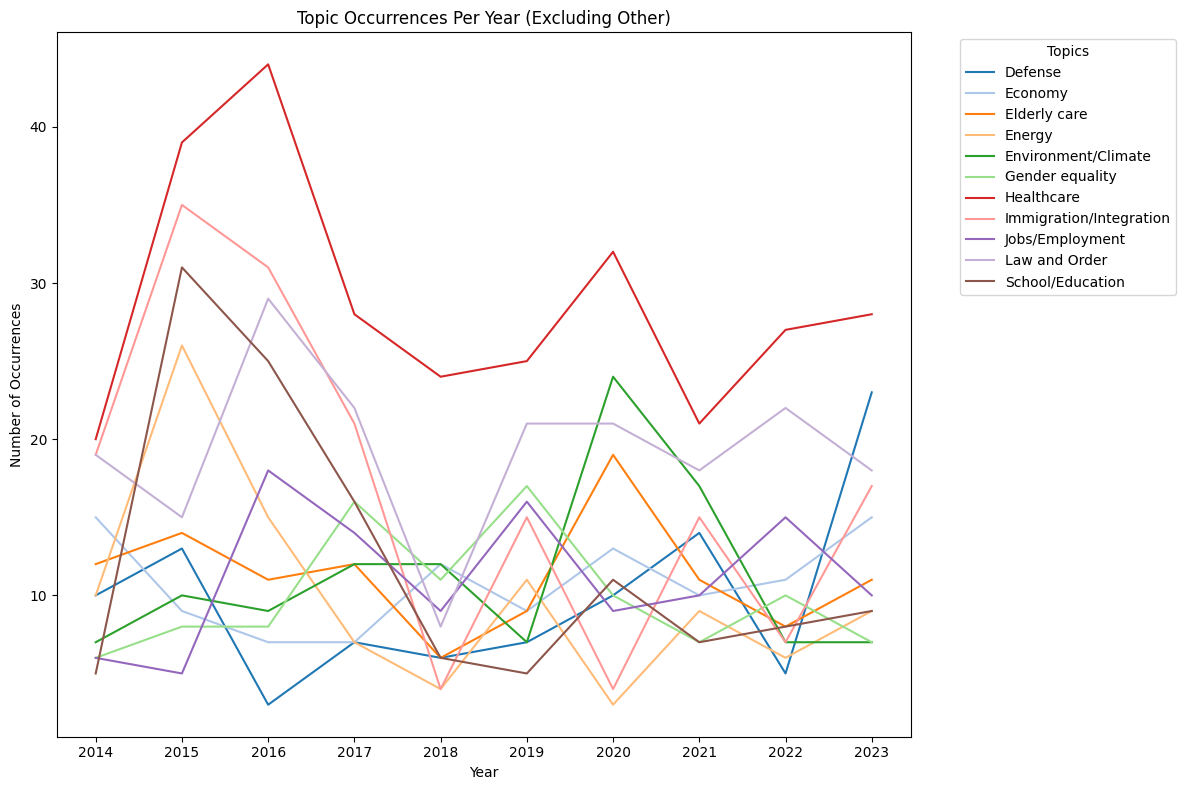

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topics_normal_name']).size().reset_index(name='count')

# Exclude "Other" from the data
topic_year_counts = topic_year_counts[topic_year_counts['guided_topics_normal_name'] != "Other"]

# Pivot data for plotting
pivot_data = topic_year_counts.pivot(index='dok_datum', columns='guided_topics_normal_name', values='count').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[topic], label=topic, color=colors[i])

plt.title('Topic Occurrences Per Year (Excluding Other)')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/2061156275.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


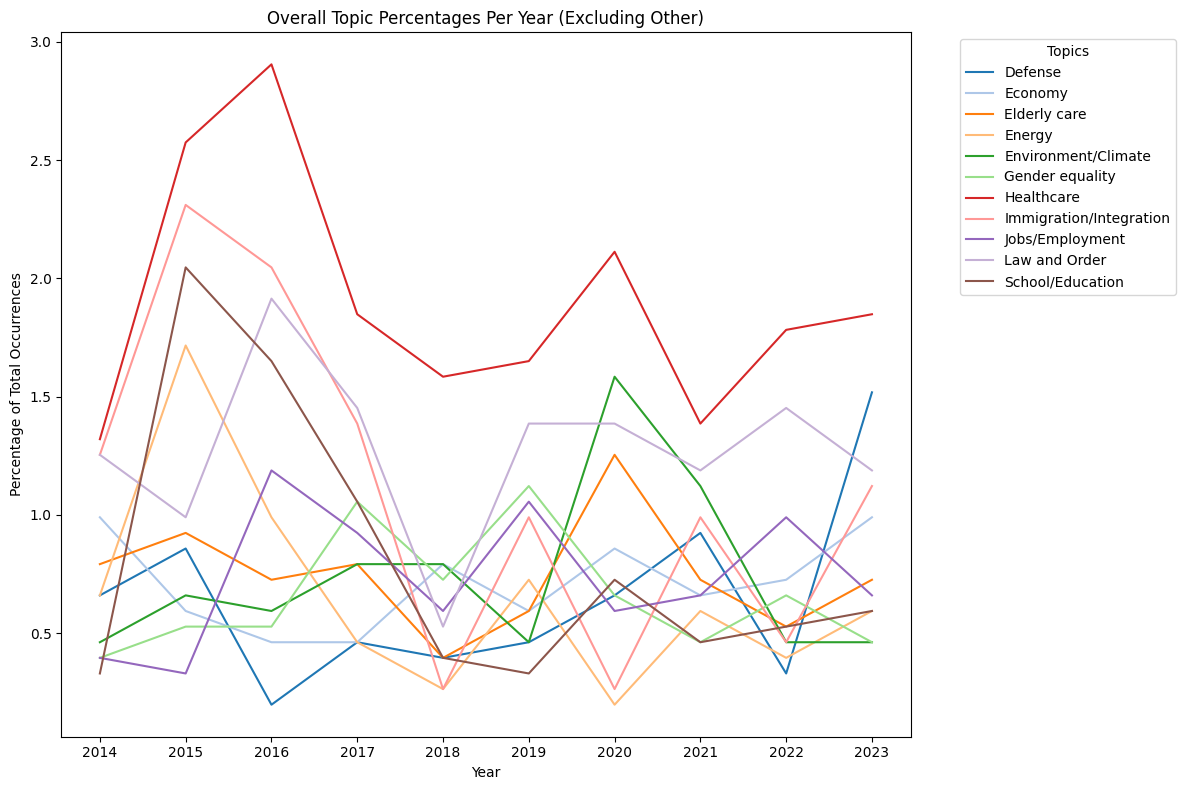

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topics_normal_name']).size().reset_index(name='count')

# Exclude "Other" from the data
topic_year_counts = topic_year_counts[topic_year_counts['guided_topics_normal_name'] != "Other"]

# Calculate overall percentages for each topic by year
topic_year_counts['percentage'] = (topic_year_counts['count'] / topic_year_counts['count'].sum()) * 100

# Pivot data for plotting
pivot_data_percentage = topic_year_counts.pivot(index='dok_datum', columns='guided_topics_normal_name', values='percentage').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data_percentage.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data_percentage.columns):
    plt.plot(pivot_data_percentage.index, pivot_data_percentage[topic], label=topic, color=colors[i])

plt.title('Overall Topic Percentages Per Year (Excluding Other)')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/1973225661.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


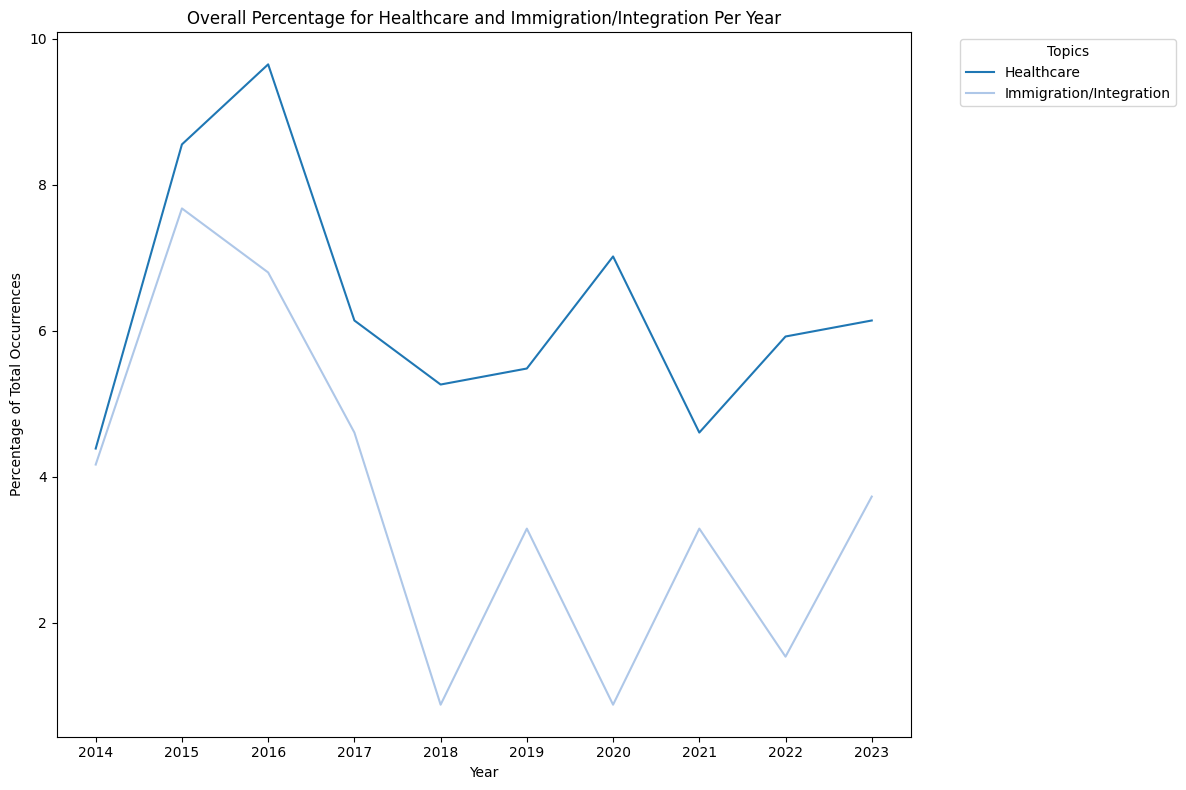

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topics_normal_name']).size().reset_index(name='count')

# Filter for "Healthcare" and "Immigration/Integration" topics
target_topics = ["Healthcare", "Immigration/Integration"]
topic_year_counts = topic_year_counts[topic_year_counts['guided_topics_normal_name'].isin(target_topics)]

# Calculate overall percentages for the selected topics
topic_year_counts['percentage'] = (topic_year_counts['count'] / topic_year_counts['count'].sum()) * 100

# Pivot data for plotting
pivot_data_percentage = topic_year_counts.pivot(index='dok_datum', columns='guided_topics_normal_name', values='percentage').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data_percentage.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data_percentage.columns):
    plt.plot(pivot_data_percentage.index, pivot_data_percentage[topic], label=topic, color=colors[i])

plt.title('Overall Percentage for Healthcare and Immigration/Integration Per Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### BERTopic Stop words and Lemma

In [23]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load a Swedish embedding model
swedish_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased")

# Initialize BERTopic with predefined seed topics
topic_model = BERTopic(
    embedding_model=swedish_model,
    seed_topic_list=seed_topic_list,
    calculate_probabilities=True, 
)

print("Fitting")
# Fit the model on your Swedish text
guided_topics, probs = topic_model.fit_transform(df_cleaned['cleaned_avsnittsrubrik'].tolist())

print("Fitted")

# Add topics back to the DataFrame
df_cleaned['guided_topic'] = guided_topics

# Map numeric topic IDs to topic names
topic_mapping = {i: topic_name for i, topic_name in enumerate(seed_topics.keys())}
df_cleaned['guided_topic_name'] = df_cleaned['guided_topic'].map(topic_mapping)

# df_cleaned['guided_topic_name'] = df_cleaned['guided_topic'].apply(
#     lambda x: topic_mapping.get(x, x)  # Use topic_mapping if exists, otherwise keep numeric topic ID
# )

# Handle "outlier" texts if needed
df_cleaned['guided_topic_name'] = df_cleaned['guided_topic_name'].fillna("Other")


Fitting
Fitted


In [ ]:
# Inspect the results
print(df_cleaned[['cleaned_avsnittsrubrik', 'guided_topic_name']].head(50))

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/362520839.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


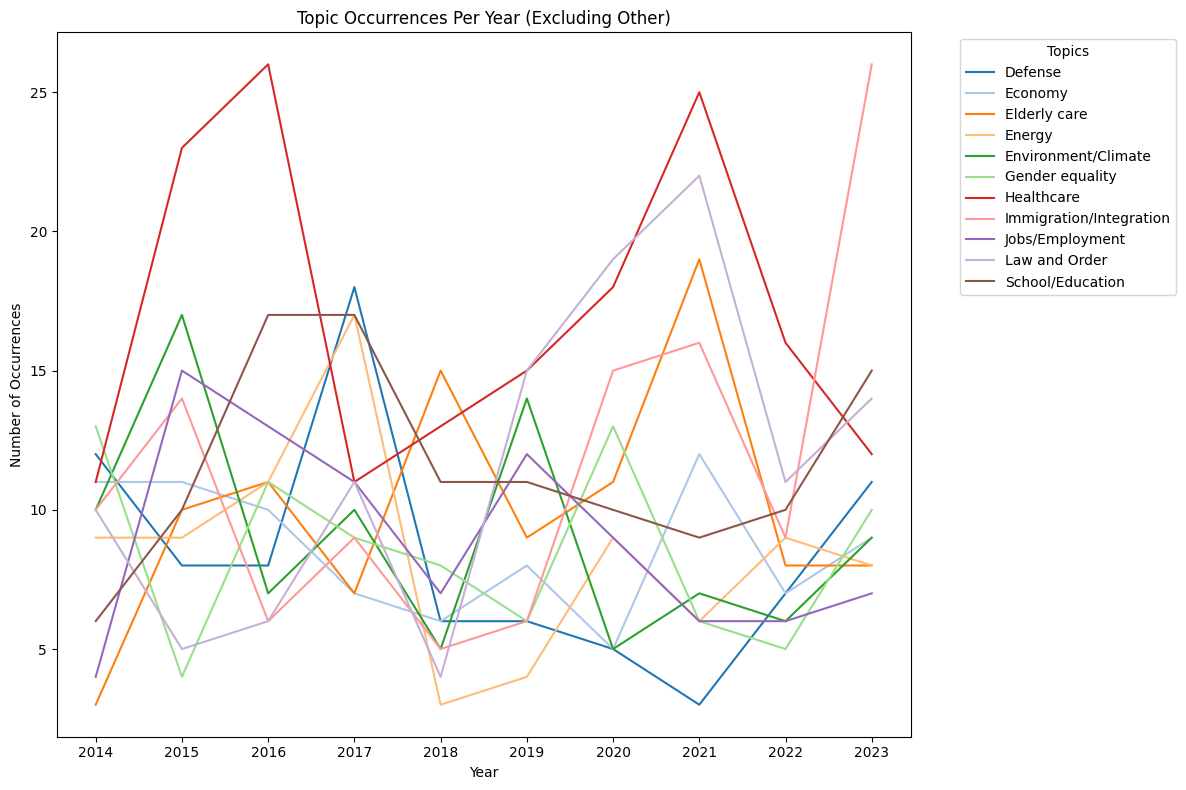

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topic_name']).size().reset_index(name='count')

# Exclude "Other" from the data
topic_year_counts = topic_year_counts[topic_year_counts['guided_topic_name'] != "Other"]

# Pivot data for plotting
pivot_data = topic_year_counts.pivot(index='dok_datum', columns='guided_topic_name', values='count').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[topic], label=topic, color=colors[i])

plt.title('Topic Occurrences Per Year (Excluding Other)')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/2459721474.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


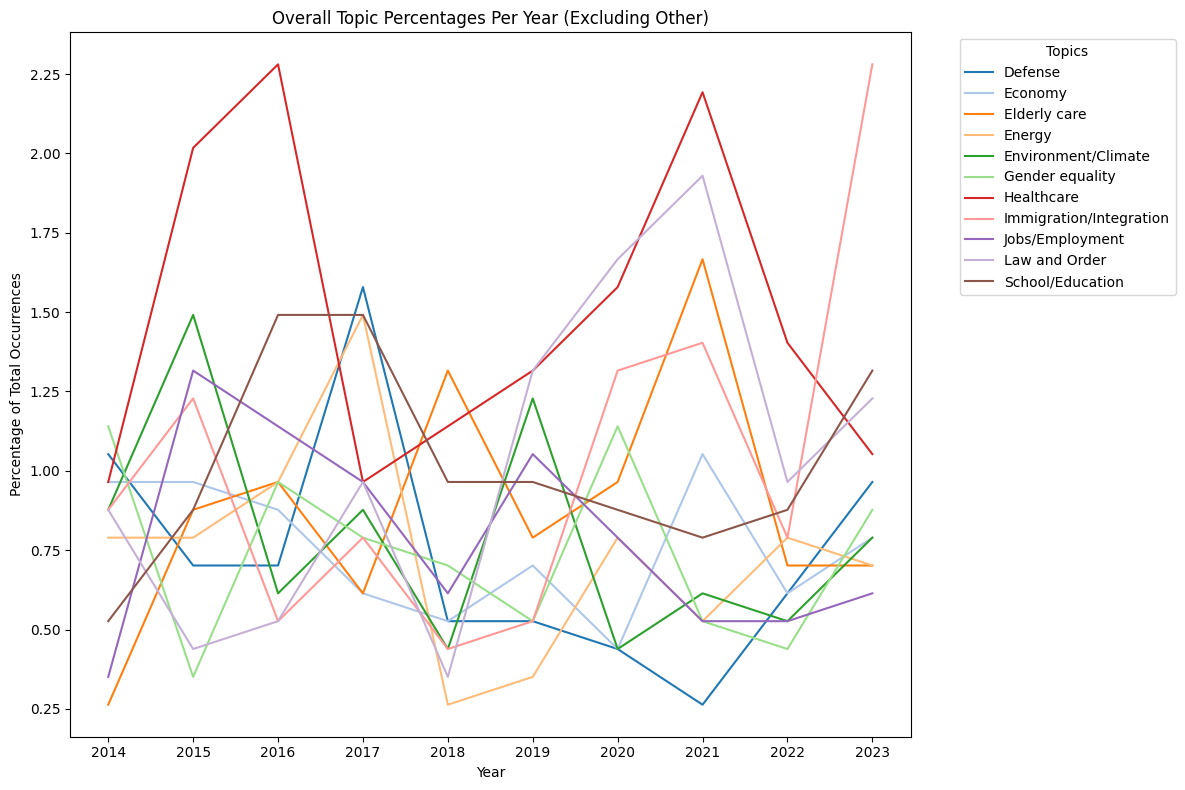

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topic_name']).size().reset_index(name='count')

# Exclude "Other" from the data
topic_year_counts = topic_year_counts[topic_year_counts['guided_topic_name'] != "Other"]

# Calculate overall percentages for each topic by year
topic_year_counts['percentage'] = (topic_year_counts['count'] / topic_year_counts['count'].sum()) * 100

# Pivot data for plotting
pivot_data_percentage = topic_year_counts.pivot(index='dok_datum', columns='guided_topic_name', values='percentage').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data_percentage.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data_percentage.columns):
    plt.plot(pivot_data_percentage.index, pivot_data_percentage[topic], label=topic, color=colors[i])

plt.title('Overall Topic Percentages Per Year (Excluding Other)')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_99501/3451879116.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


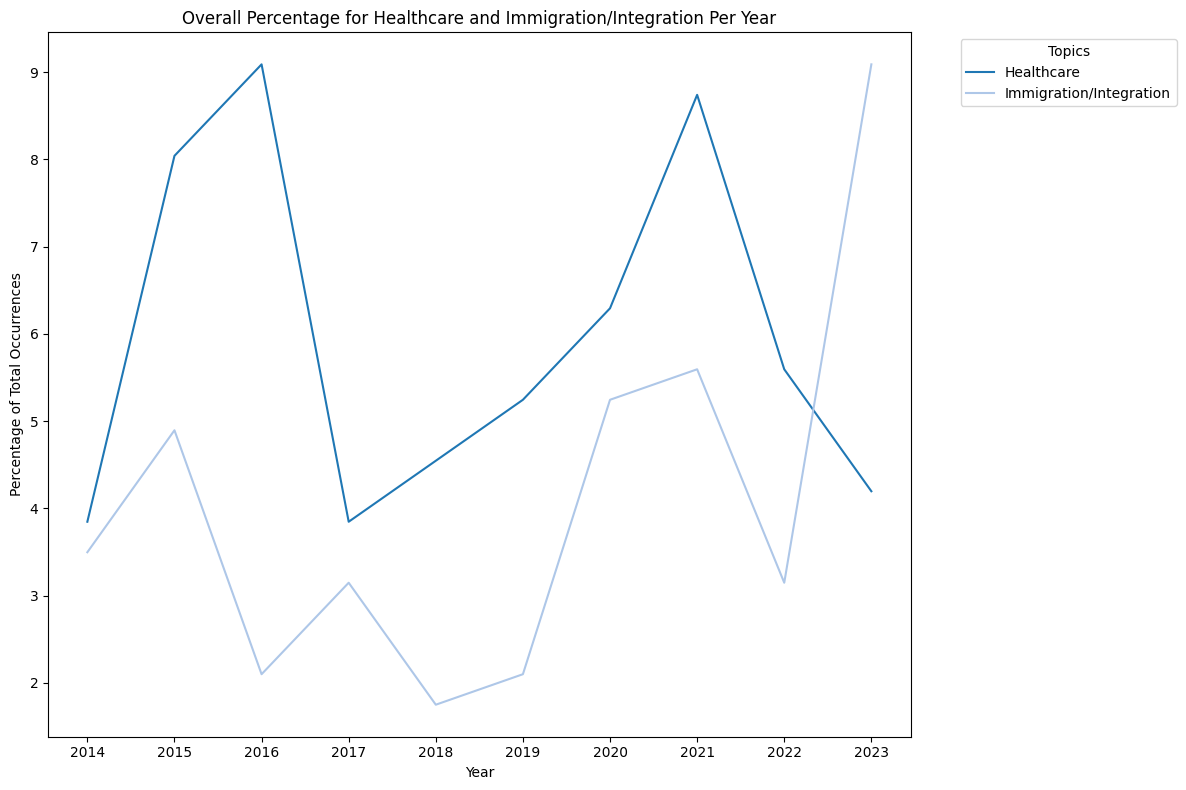

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topic_name']).size().reset_index(name='count')

# Filter for "Healthcare" and "Immigration/Integration" topics
target_topics = ["Healthcare", "Immigration/Integration"]
topic_year_counts = topic_year_counts[topic_year_counts['guided_topic_name'].isin(target_topics)]

# Calculate overall percentages for the selected topics
topic_year_counts['percentage'] = (topic_year_counts['count'] / topic_year_counts['count'].sum()) * 100

# Pivot data for plotting
pivot_data_percentage = topic_year_counts.pivot(index='dok_datum', columns='guided_topic_name', values='percentage').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data_percentage.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data_percentage.columns):
    plt.plot(pivot_data_percentage.index, pivot_data_percentage[topic], label=topic, color=colors[i])

plt.title('Overall Percentage for Healthcare and Immigration/Integration Per Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Other

In [28]:
topic_info = topic_model.get_topic_info()
print(topic_info)

     Topic  Count                                               Name  \
0       -1   3539                            -1_eu_eus_rysk_tillväxt   
1        0    170              0_bonus_malus_slutförvar_extratjänsta   
2        1    117                    1_våld_sexualbrott_sexuell_nära   
3        2    116       2_barn_ensamkommande_vårdnadstvist_barnfråga   
4        3    116    3_hälso_sjukvård_sjukvårdsfråga_patientsäkerhet   
..     ...    ...                                                ...   
371    370     11             370_interparlamentarisk_ipu_union_unio   
372    371     10           371_mänsklig_utrikespolitik_rättighet_fn   
373    372     10            372_gåva_avdragsrätt_ideell_avdragsgill   
374    373     10  373_jobbskatteavdrag_fackföreningsavgift_skatt...   
375    374     10  374_socialtjänst_samhällstjänst_arbetsmetoda_s...   

                                        Representation  \
0    [eu, eus, rysk, tillväxt, bostad, interpellati...   
1    [bonus, malus,

In [29]:
import pandas as pd

# Convert to a DataFrame for better visualization
topic_counts_df = topic_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Count']
display(topic_counts_df)


NameError: name 'topic_counts' is not defined

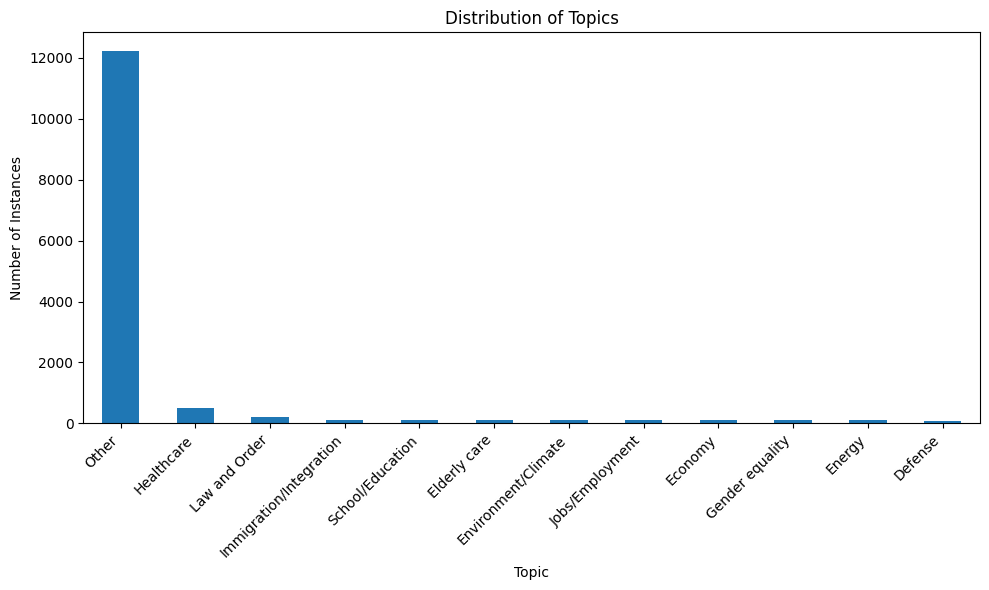

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each topic
topic_counts = df_cleaned['guided_topic_name'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')  # Rotate topic names for better readability
plt.tight_layout()
plt.show()


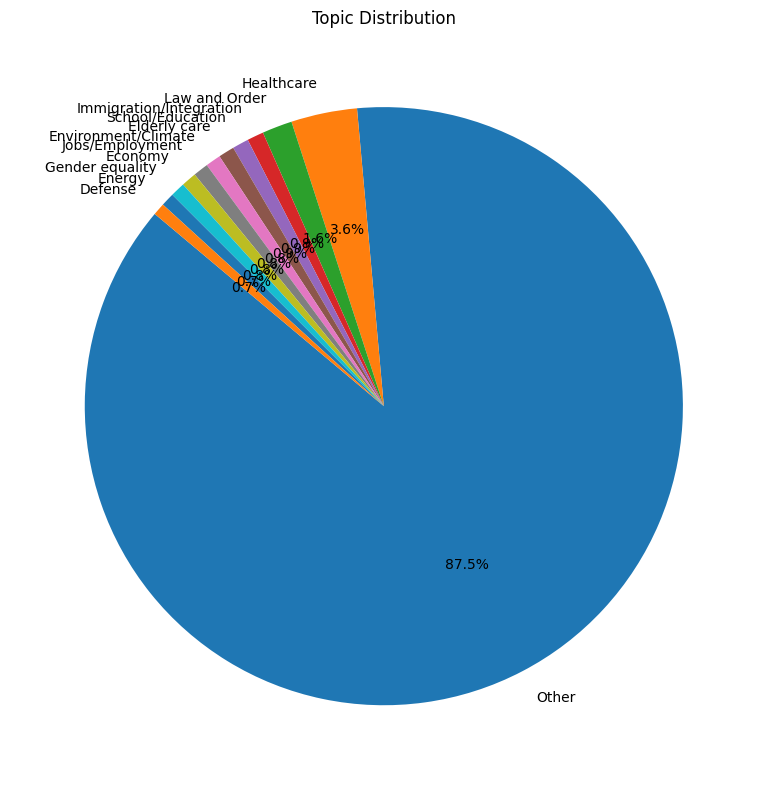

In [47]:
# Plot a pie chart
plt.figure(figsize=(8, 8))
topic_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Topic Distribution')
plt.ylabel('')  # Hide the y-axis label for aesthetics
plt.tight_layout()
plt.show()
